In [19]:


#%%
import os
import sys
import json
from argparse import ArgumentParser
import yaml
import torch
import random
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
# personal files
import models
from datasets import MelDataset, vctkDataset, greatbirdDataset


os.chdir('/mnt/work/')
# ------------------------------------------------------------------------
# config loading
data_config_path = "./Animal/configs/greatbird/dataset_greatbird_chunk.yaml"

# model name
#------------------------------------------------------------------------
# exp_name = 'VectorVAEbase-greatbird_Vector -c_100.0_1.3-i_10.0'
# checkpoint = "45000.pth.tar"
#------------------------------------------------------------------------
# model path
# model_config_path = "./Animal/configs/greatbird/model_greatbird_Vector.yaml"
# model_path = './Animal/output/greatbird'
# exp_name = 'VectorVAEbase-greatbird_Vector3-c_100.0_1.0-i_5.0'
# checkpoint = "190000.pth.tar"
# key_posi = [1, 17, 22, 23, 25, 30, 34, 37, 43, 46, 58, 60, 67, 92, 100, 111, 112, 125, 126]
#------------------------------------------------------------------------
model_config_path = "./Animal/configs/greatbird/model_greatbird_Vector2.yaml"
model_path = './Animal/output/greatbird'
exp_name = 'VectorVAEbase-greatbird_Vector6-c_80.0_3.2-i_1.0'
checkpoint = "75000.pth.tar"
key_posi = [1, 17, 22, 23, 25, 30, 34, 37, 43, 46, 58, 60, 67, 92, 100, 111, 112, 125, 126]


# device
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# ------------------------------------------------------------------------

# dataset vctk
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
# analy_set = greatbirdDataset(dataset_config, subset='test')
analy_set = greatbirdDataset(dataset_config, subset='train')

analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)

# model loading
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(model_config, device).to(device) # model config load

#load model
save_path = os.path.join(model_path, exp_name, 'checkpoint', checkpoint)
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()

# data store
total_z_indi = []
total_z_q = []

total_z_con_mu = []
total_z_con_log_std = []
total_z_con = []

total_x_gt = [] # mel
total_x_rec = [] # reconstuct mel
total_cID = []
total_ctID = []


total_key_indi = []

for mel, lenx, indi_mel, cID, cID_type in tqdm(analy_loader):
        mel = mel.to(device)
        lenx = lenx.to(device)
        indi_mel = indi_mel.to(device)
        
        outputs = model(mel, lenx, indi_mel) 
        z_indi = outputs['z_indi'].detach().cpu().numpy() 
        z_q = outputs['z_q'].detach().cpu().numpy() 
                
        z_con_mu = outputs['con_mu'].detach().cpu().numpy() 
        z_con_log_std = outputs['con_log_std'].detach().cpu().numpy() 
        z_con = outputs['z_con'].detach().cpu().numpy() 
        x_rec = outputs['x_rec'].detach().cpu().numpy() 
        
        # indi z & q
        total_z_indi.append(z_indi)
        total_z_q.append(z_q)
        # extracte key position of total_z_indi_mu [:,11] 
        total_key_indi.append([z_indi[:,i] for i in key_posi])
        
        # content 
        total_z_con_mu.append(z_con_mu)
        total_z_con_log_std.append(z_con_log_std)
        total_z_con.append(z_con)
        
        total_x_gt.append(mel.detach().cpu().numpy())
        total_x_rec.append(x_rec)
        
        # print('cID',cID[0][1:])
        total_cID.append(cID[0])
        total_ctID.append(cID_type[0])
        
        
    
unique_elements, counts = np.unique(total_cID, return_counts=True)
times = 0
for element, count in zip(unique_elements, counts):
    times += 1
    print('cID_counts',f"{element}: {count}")
print('times',times)


dataset greatbird loading...


100%|██████████| 30268/30268 [08:10<00:00, 61.66it/s] 

cID_counts B108: 33
cID_counts B116: 183
cID_counts B119: 41
cID_counts B14: 35
cID_counts B161: 10
cID_counts B163: 124
cID_counts B169: 252
cID_counts B171: 183
cID_counts B174: 19
cID_counts B175: 44
cID_counts B18: 5
cID_counts B194: 7
cID_counts B203: 186
cID_counts B205: 13
cID_counts B208: 51
cID_counts B216: 2
cID_counts B225: 17
cID_counts B226: 111
cID_counts B227: 57
cID_counts B27: 6
cID_counts B3: 103
cID_counts B31: 120
cID_counts B32: 180
cID_counts B35: 37
cID_counts B36: 183
cID_counts B43: 197
cID_counts B44: 6
cID_counts B5: 42
cID_counts B60: 116
cID_counts B62A: 11
cID_counts B65: 530
cID_counts B72: 24
cID_counts B78: 312
cID_counts B79: 2
cID_counts C107: 25
cID_counts C110: 8
cID_counts C115: 54
cID_counts C118: 99
cID_counts C136: 74
cID_counts C143: 24
cID_counts C148: 305
cID_counts C151: 217
cID_counts C152: 214
cID_counts C153: 145
cID_counts C157: 112
cID_counts C160B: 56
cID_counts C163: 90
cID_counts C24C: 62
cID_counts C25: 419
cID_counts C26: 44
cID_co

In [20]:
used_label = total_ctID
unique_labels = np.unique(used_label)
unique_labels

array(['B108_0', 'B108_2', 'B108_3', ..., 'W99_4', 'W99_5', 'W99_7'],
      dtype='<U8')

In [21]:
# test key posti of indi miu
from sklearn.manifold import TSNE

# call type
key_indi = np.array(total_key_indi).squeeze()

print('key_indi',key_indi.shape)

# choose some caller vector
key_indi = key_indi[:,0:17]
# indics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
# key_indi_mu = key_indi_mu[:,indics]

# tsne
tsne = TSNE(n_components = 2, perplexity = 35, n_iter = 1000)
key_posi_total = tsne.fit_transform(key_indi)

key_indi (30268, 19)


key_posi_total (30268, 17)


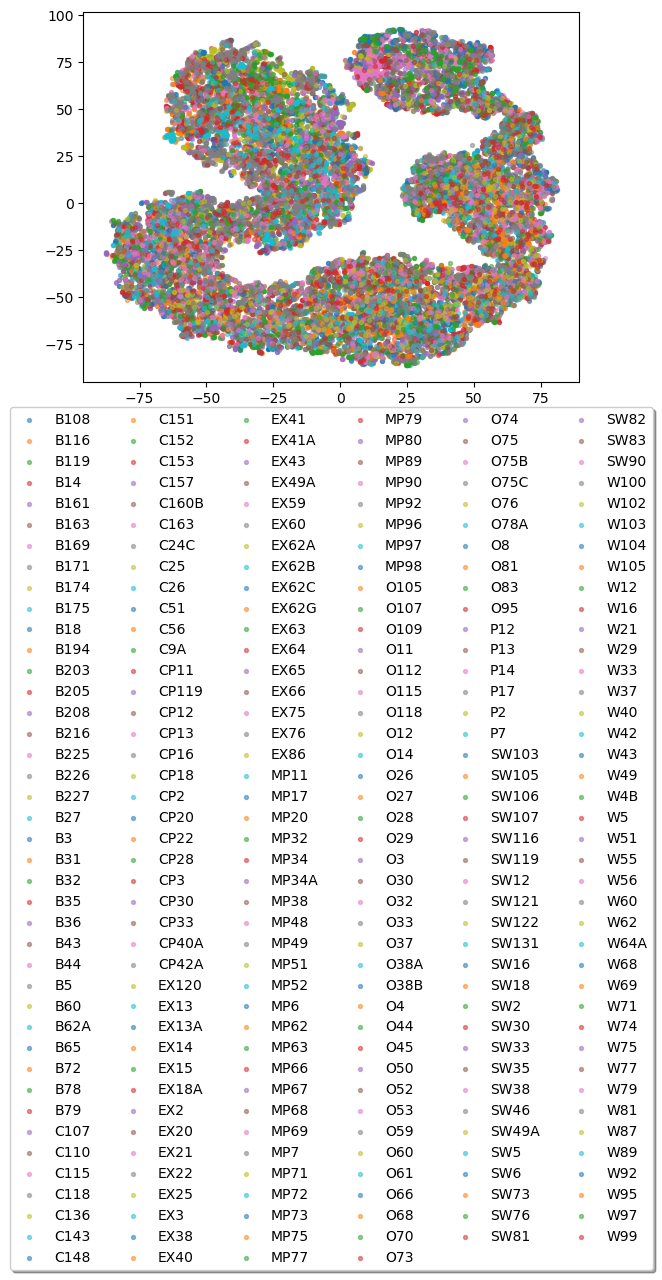

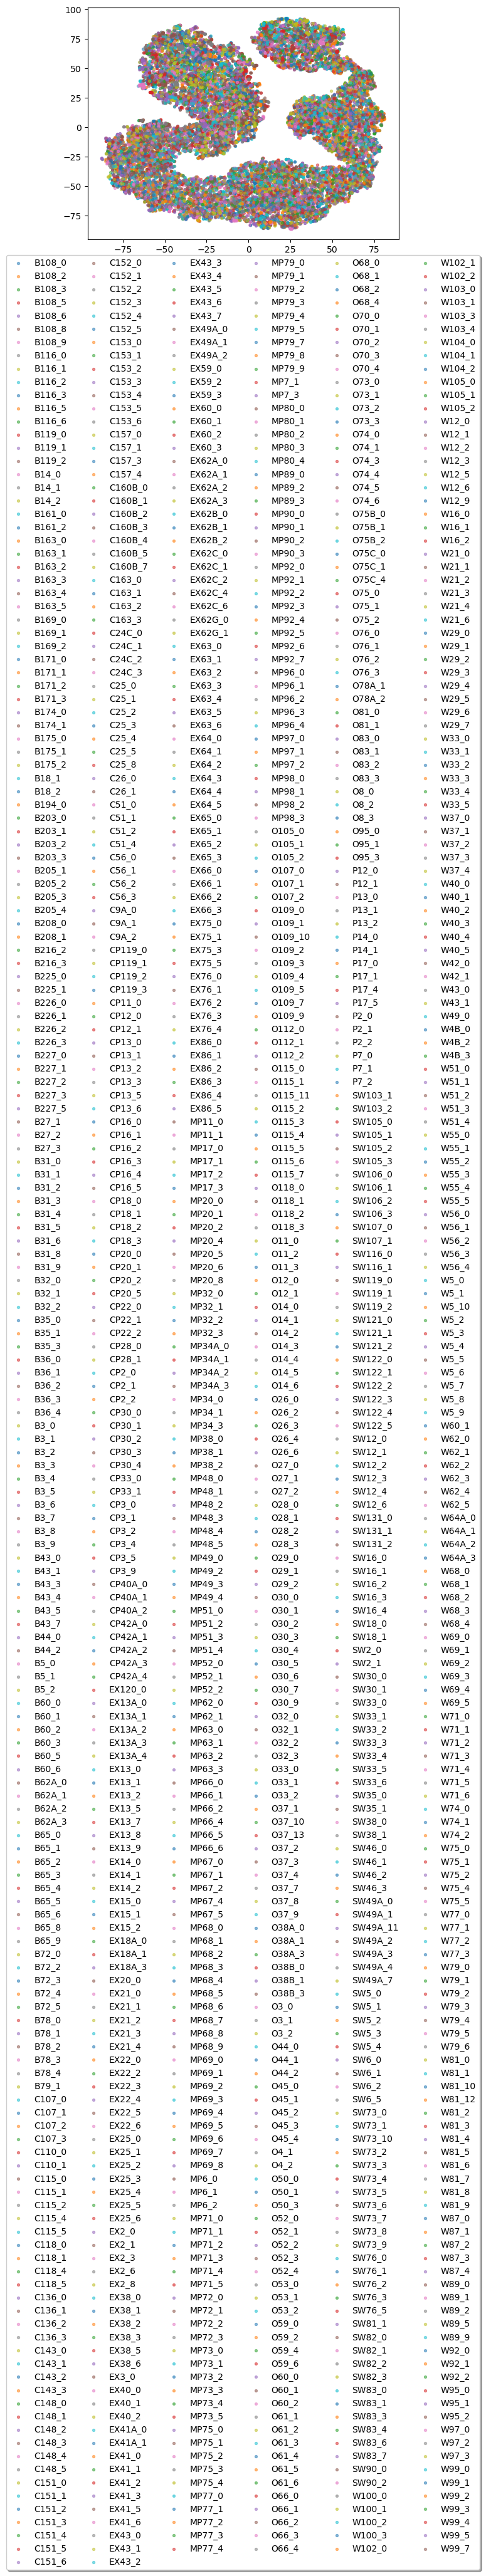

In [22]:
print('key_posi_total',key_indi.shape)

key_used_label = np.expand_dims(total_cID, axis=0)
key_unique_labels = np.unique(key_used_label)
# print(key_posi_total.shape)
# print(used_label)
# print(unique_labels)
 
for label in key_unique_labels:
    # 这里我们不需要指定axis，因为used_label只有一行
    label_mask = np.all(key_used_label == label, axis=0)
    # Select data for this label
    data_for_label = key_posi_total[label_mask]
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

# Add a legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
plt.show()

key_used_label = np.expand_dims(total_ctID, axis=0)
key_unique_labels = np.unique(key_used_label)
for label in key_unique_labels:
    # 这里我们不需要指定axis，因为used_label只有一行
    label_mask = np.all(key_used_label == label, axis=0)
    # Select data for this label
    data_for_label = key_posi_total[label_mask]
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

# Add a legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
plt.show()
    

In [23]:
from sklearn.manifold import TSNE

# call type
total_z_con_1D = []
for i in total_z_con_mu: # total_z_con; content miu: total_z_con_mu; content var: total_z_con_log_std
    total_z_con_1D.append(i.sum(2))
    # total_z_con_1D.append(i.mean(2))

# tsne
total_z_con_1D = np.array(total_z_con_1D).squeeze()
tsne = TSNE(n_components = 2, perplexity = 30, n_iter = 1000)

# print('total_z_con_1D',total_z_con_1D[0])

data_2d_con = tsne.fit_transform(total_z_con_1D) # cnontent


data choose from label (8889, 2)
label choose from label (1, 8889)
unique label choose from label (71,)


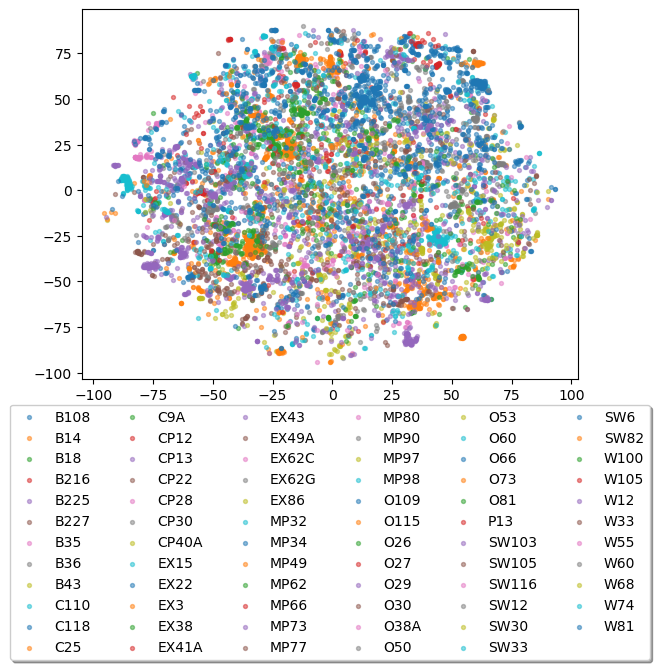

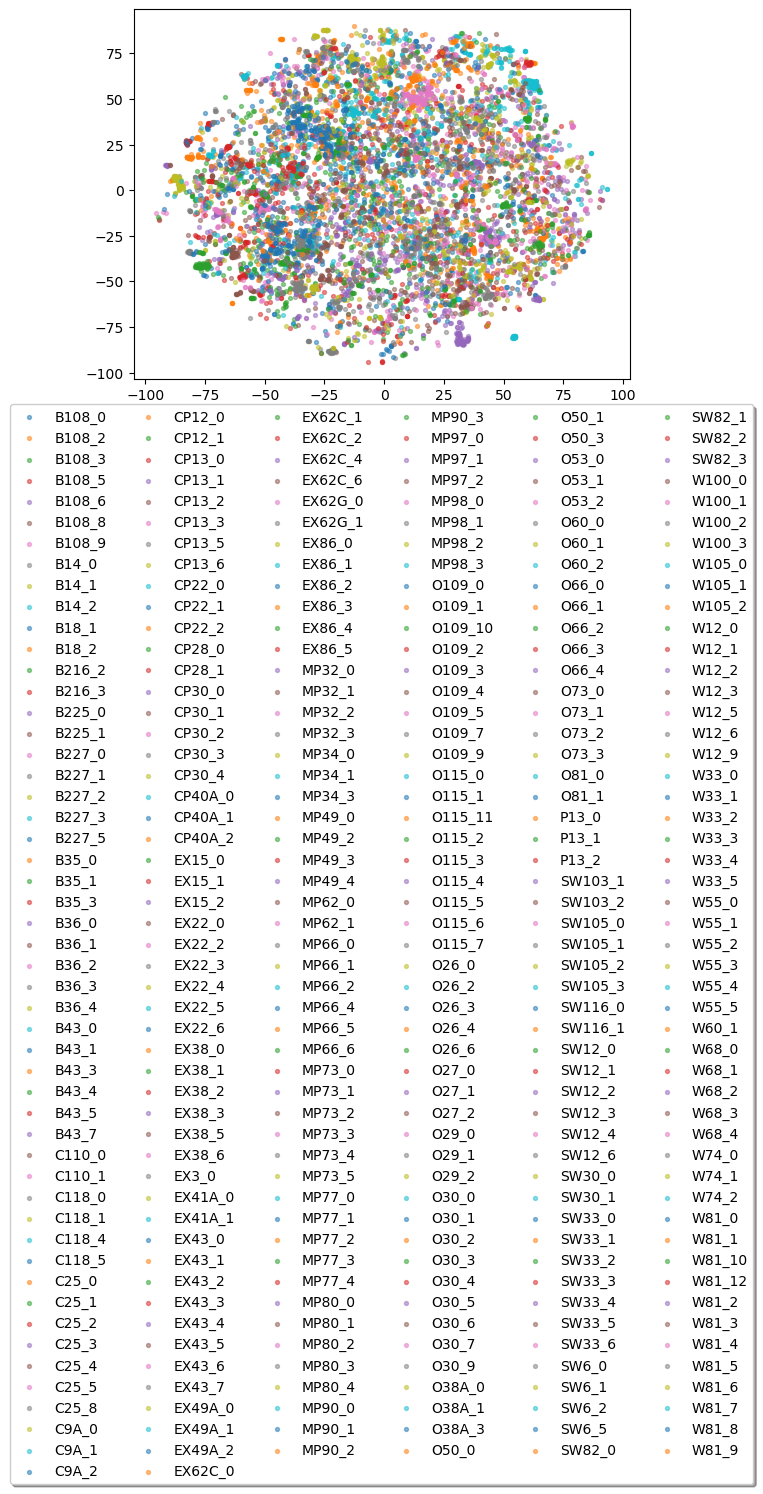

data choose from label (463, 2)
label choose from label (1, 463)
unique label choose from label (5,)


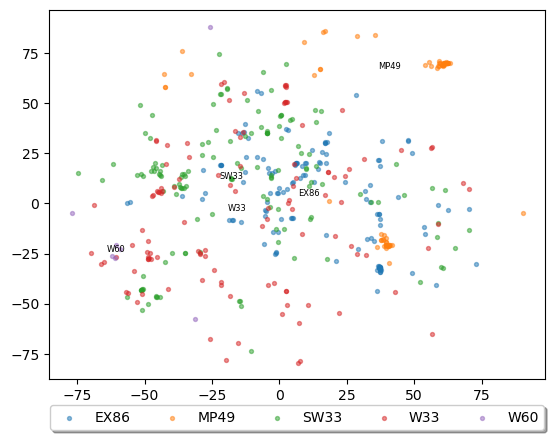

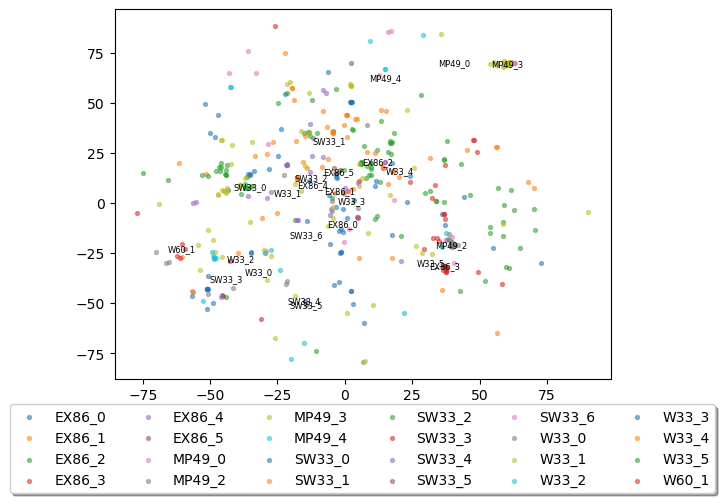

In [24]:

# Get unique labels
# caller
total_cID = np.array(total_cID)
used_label = np.expand_dims(total_cID, axis=0)

# caller_class
total_ctID = np.array(total_ctID)
caller_type_label = np.expand_dims(total_ctID, axis=0)
# ------------------------------------------------------------------------
# use data segment
# ran_data = True
ran_data = False
if ran_data:
    num_samples = 5000
    random.seed(0)
    rand = list(range(len(data_2d_con)))
    samples = random.sample(rand, num_samples)
    data_2d_con_seg = data_2d_con[samples,]
    used_label_seg = used_label[:,samples]
    unique_labels = np.unique(used_label_seg)
else:
    # not random choose data segment
    data_2d_con_seg = data_2d_con
    used_label_seg = used_label
    unique_labels = np.unique(used_label_seg)
    # print(data_2d_con.shape)
    # print(unique_labels.shape)
    # print(unique_labels)


# select data from data label
# random select
# num_label = 5
# num_label = 71


con_text = [False, True]
con_iter = iter(con_text) 

for num_label in [71, 5]: 
    
    random.seed(0)
    rand_label_num = list(range(len(unique_labels)))
    rand_label = random.sample(rand_label_num, num_label)
    used_label_index = unique_labels[rand_label]

    # choose label
    # used_label_index = ['B101', 'B165',  'B221',  'B39',  'B4', 'B57']
    # ['B101' 'B165' 'B221' 'B39' 'B4' 'B57' 'B67' 'B98' 'C1' 'C10' 'C108'
    #  'C109' 'C12' 'C16' 'C4' 'C47' 'C61A' 'EX10' 'EX19A' 'EX29' 'EX34' 'EX51'
    #  'EX57' 'EX62' 'EX62E' 'EX62F' 'MP12' 'MP29' 'MP41' 'MP42' 'MP50' 'MP55'
    #  'MP57' 'MP61' 'MP64' 'MP65' 'MP76' 'MP78' 'O113' 'O21' 'O27A' 'O36' 'O48'
    #  'O56' 'O6' 'O75D' 'O78' 'O82' 'O93' 'P11' 'P6' 'SW1' 'SW102' 'SW114'
    #  'SW128' 'SW19' 'SW28' 'SW32' 'SW34' 'SW49' 'SW60' 'SW9' 'W103A' 'W17'
    #  'W18' 'W28' 'W35' 'W36' 'W67' 'W73' 'W80']

    # mask to selected data label
    mask = np.isin(used_label_seg, used_label_index)
    # print(mask)
    indices = np.where(mask)[1]
    # print(indices)
    data_spk_label = data_2d_con_seg[indices,]
    used_spk_label = used_label_seg[:,indices]
    used_spk_type_label = caller_type_label[:,indices]

    unique_spk_label = np.unique(used_spk_label)
    unique_spk_type_label = np.unique(used_spk_type_label)

    print('data choose from label',data_spk_label.shape)
    # print(data_spk_label)
    print('label choose from label',used_spk_label.shape)
    # print(used_spk_label)
    print('unique label choose from label',unique_spk_label.shape)
    # print(unique_spk_label)

    # paint index
    next_item = next(con_iter)
    
    for label in unique_spk_label:
        label_mask = np.all(used_spk_label == label, axis=0)
        
        # print('label',label)
        # print(label_mask)
        # Select data for this label
        data_for_label = data_spk_label[label_mask]
        
        # Plot the data for this label with a label for the legend
        plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

        # center prosition
        centroid = np.median(data_for_label, axis=0)
        # text label
        if next_item:
            plt.text(centroid[0], centroid[1], str(label), fontsize=6, color='black', ha='center', va='center')

    # Add a legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
    plt.show()


    for label in unique_spk_type_label:
        label_mask = np.all(used_spk_type_label == label, axis=0)
        
        # print('label',label)
        # print(label_mask)
        # Select data for this label
        data_for_label = data_spk_label[label_mask]
        
        # Plot the data for this label with a label for the legend
        plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

        # center prosition
        centroid = np.median(data_for_label, axis=0)
        # text label
        if next_item:
            plt.text(centroid[0], centroid[1], str(label), fontsize=6, color='black', ha='center', va='center')

    # Add a legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
    plt.show()

In [25]:
from sklearn.manifold import TSNE

# total_z_con = 
# caller
total_z_indi = np.array(total_z_indi).squeeze() # indi
total_z_q = np.array(total_z_q).squeeze()

# tsne
tsne = TSNE(n_components=2, perplexity = 30, n_iter = 1000)
# change data
# data_2d_speaker = tsne.fit_transform(total_z_indi)
data_2d_speaker = tsne.fit_transform(total_z_q)



(30268, 128)
(128,)


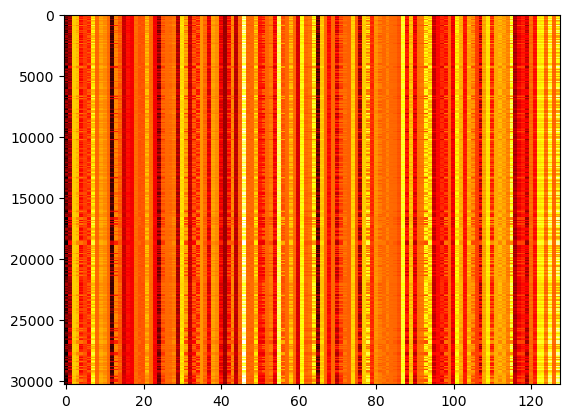

In [26]:
i = 101
print(total_z_q.shape)
print(total_z_q[i].shape)
plt.plot(total_z_q[i])
plt.imshow(total_z_q, aspect='auto', cmap='hot', interpolation='nearest')
plt.show()

total label 244 ['B108' 'B116' 'B119' 'B14' 'B161' 'B163' 'B169' 'B171' 'B174' 'B175'
 'B18' 'B194' 'B203' 'B205' 'B208' 'B216' 'B225' 'B226' 'B227' 'B27' 'B3'
 'B31' 'B32' 'B35' 'B36' 'B43' 'B44' 'B5' 'B60' 'B62A' 'B65' 'B72' 'B78'
 'B79' 'C107' 'C110' 'C115' 'C118' 'C136' 'C143' 'C148' 'C151' 'C152'
 'C153' 'C157' 'C160B' 'C163' 'C24C' 'C25' 'C26' 'C51' 'C56' 'C9A' 'CP11'
 'CP119' 'CP12' 'CP13' 'CP16' 'CP18' 'CP2' 'CP20' 'CP22' 'CP28' 'CP3'
 'CP30' 'CP33' 'CP40A' 'CP42A' 'EX120' 'EX13' 'EX13A' 'EX14' 'EX15'
 'EX18A' 'EX2' 'EX20' 'EX21' 'EX22' 'EX25' 'EX3' 'EX38' 'EX40' 'EX41'
 'EX41A' 'EX43' 'EX49A' 'EX59' 'EX60' 'EX62A' 'EX62B' 'EX62C' 'EX62G'
 'EX63' 'EX64' 'EX65' 'EX66' 'EX75' 'EX76' 'EX86' 'MP11' 'MP17' 'MP20'
 'MP32' 'MP34' 'MP34A' 'MP38' 'MP48' 'MP49' 'MP51' 'MP52' 'MP6' 'MP62'
 'MP63' 'MP66' 'MP67' 'MP68' 'MP69' 'MP7' 'MP71' 'MP72' 'MP73' 'MP75'
 'MP77' 'MP79' 'MP80' 'MP89' 'MP90' 'MP92' 'MP96' 'MP97' 'MP98' 'O105'
 'O107' 'O109' 'O11' 'O112' 'O115' 'O118' 'O12' 'O14' 'O26' 'O

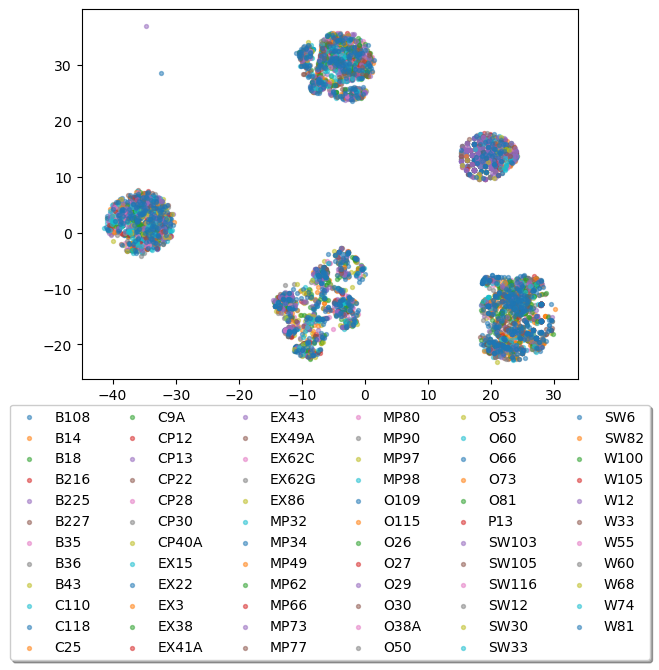

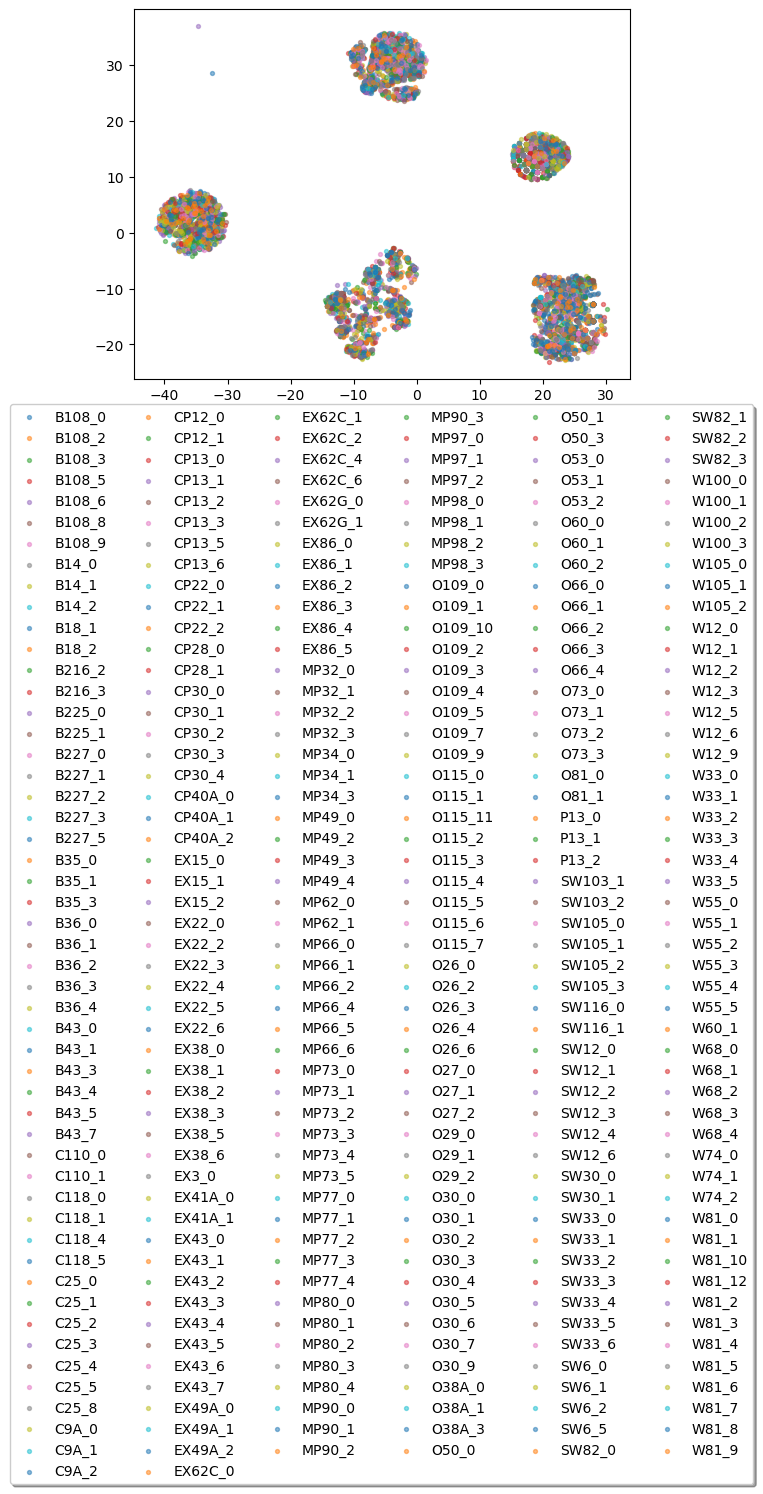

total label 244 ['B108' 'B116' 'B119' 'B14' 'B161' 'B163' 'B169' 'B171' 'B174' 'B175'
 'B18' 'B194' 'B203' 'B205' 'B208' 'B216' 'B225' 'B226' 'B227' 'B27' 'B3'
 'B31' 'B32' 'B35' 'B36' 'B43' 'B44' 'B5' 'B60' 'B62A' 'B65' 'B72' 'B78'
 'B79' 'C107' 'C110' 'C115' 'C118' 'C136' 'C143' 'C148' 'C151' 'C152'
 'C153' 'C157' 'C160B' 'C163' 'C24C' 'C25' 'C26' 'C51' 'C56' 'C9A' 'CP11'
 'CP119' 'CP12' 'CP13' 'CP16' 'CP18' 'CP2' 'CP20' 'CP22' 'CP28' 'CP3'
 'CP30' 'CP33' 'CP40A' 'CP42A' 'EX120' 'EX13' 'EX13A' 'EX14' 'EX15'
 'EX18A' 'EX2' 'EX20' 'EX21' 'EX22' 'EX25' 'EX3' 'EX38' 'EX40' 'EX41'
 'EX41A' 'EX43' 'EX49A' 'EX59' 'EX60' 'EX62A' 'EX62B' 'EX62C' 'EX62G'
 'EX63' 'EX64' 'EX65' 'EX66' 'EX75' 'EX76' 'EX86' 'MP11' 'MP17' 'MP20'
 'MP32' 'MP34' 'MP34A' 'MP38' 'MP48' 'MP49' 'MP51' 'MP52' 'MP6' 'MP62'
 'MP63' 'MP66' 'MP67' 'MP68' 'MP69' 'MP7' 'MP71' 'MP72' 'MP73' 'MP75'
 'MP77' 'MP79' 'MP80' 'MP89' 'MP90' 'MP92' 'MP96' 'MP97' 'MP98' 'O105'
 'O107' 'O109' 'O11' 'O112' 'O115' 'O118' 'O12' 'O14' 'O26' 'O

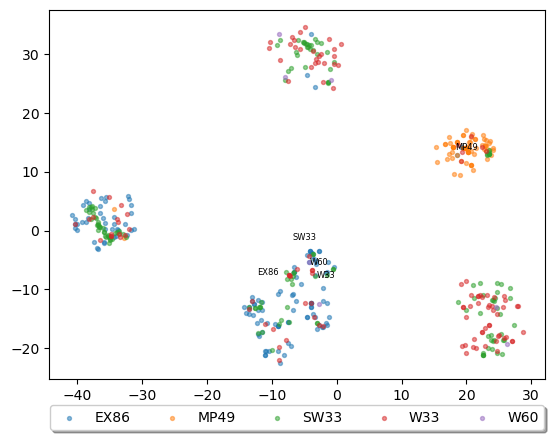

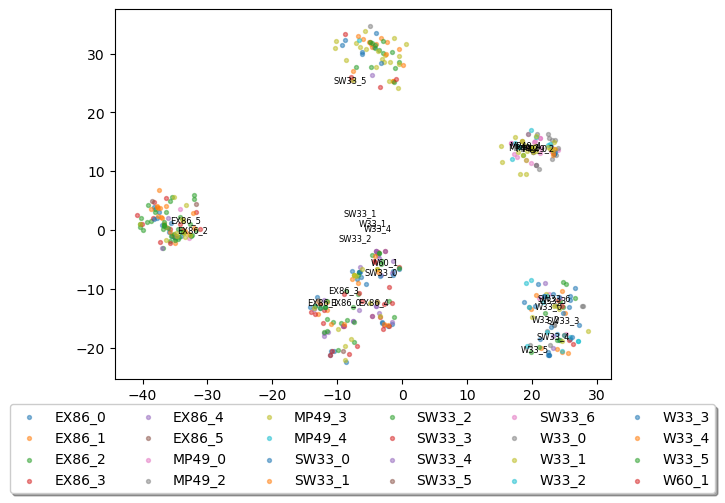

In [27]:
# Get unique labels
# caller
total_cID = np.array(total_cID)
used_label = np.expand_dims(total_cID, axis=0)

# caller_class
total_ctID = np.array(total_ctID)
caller_type_label = np.expand_dims(total_ctID, axis=0)

# use data segment
# ran_data = True
ran_data = False
if ran_data:
    num_samples = 5000
    random.seed(0)
    rand = list(range(len(data_2d_speaker)))
    samples = random.sample(rand, num_samples)
    data_2d_spk_seg = data_2d_speaker[samples,]
    used_label_seg = used_label[:,samples]
    unique_labels = np.unique(used_label_seg)
else:
    # not random choose data segment
    data_2d_spk_seg = data_2d_speaker
    used_label_seg = used_label
    unique_labels = np.unique(used_label_seg)
    # print(data_2d_con.shape)
    # print(unique_labels.shape)
    # print(unique_labels)


# select data from data label
# random select
# num_label = 5
# num_label = 71

con_text = [False, True]
# con_text = [True, True]
con_iter = iter(con_text) 

for num_label in [71, 5]: 
    random.seed(0)
    rand_label_num = list(range(len(unique_labels)))
    rand_label = random.sample(rand_label_num, num_label)
    used_label_index = unique_labels[rand_label]

    # choose label
    # used_label_index = ['B101', 'B165',  'B221',  'B39',  'B4', 'B57']
    # ['B101' 'B165' 'B221' 'B39' 'B4' 'B57' 'B67' 'B98' 'C1' 'C10' 'C108'
    #  'C109' 'C12' 'C16' 'C4' 'C47' 'C61A' 'EX10' 'EX19A' 'EX29' 'EX34' 'EX51'
    #  'EX57' 'EX62' 'EX62E' 'EX62F' 'MP12' 'MP29' 'MP41' 'MP42' 'MP50' 'MP55'
    #  'MP57' 'MP61' 'MP64' 'MP65' 'MP76' 'MP78' 'O113' 'O21' 'O27A' 'O36' 'O48'
    #  'O56' 'O6' 'O75D' 'O78' 'O82' 'O93' 'P11' 'P6' 'SW1' 'SW102' 'SW114'
    #  'SW128' 'SW19' 'SW28' 'SW32' 'SW34' 'SW49' 'SW60' 'SW9' 'W103A' 'W17'
    #  'W18' 'W28' 'W35' 'W36' 'W67' 'W73' 'W80']

    print('total label',len(np.unique(used_label)),np.unique(used_label))
    print('rand choosed label name',len(used_label_index),used_label_index)


    # mask to selected data label
    mask = np.isin(used_label_seg, used_label_index)
    # print(mask)
    indices = np.where(mask)[1]
    # print(indices)
    data_spk_label = data_2d_spk_seg[indices,]
    used_spk_label = used_label_seg[:,indices]
    used_spk_type_label = caller_type_label[:,indices]
    unique_spk_label = np.unique(used_spk_label)
    unique_spk_type_label = np.unique(used_spk_type_label)

    print('data choose from label',data_spk_label.shape)
    # print(data_spk_label)
    print('label choose from label',used_spk_label.shape)
    # print(used_spk_label)
    print('unique label type choose from label',unique_spk_type_label.shape)
    print('unique label choose from label',unique_spk_label.shape)
    # print(unique_spk_label)

    # paint index
    next_item = next(con_iter)
    
    for label in unique_spk_label:
        label_mask = np.all(used_spk_label == label, axis=0)
        
        # print('label',label)
        # print(label_mask)
        # Select data for this label
        data_for_label = data_spk_label[label_mask]
        
        # Plot the data for this label with a label for the legend
        plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

        # center prosition
        centroid = np.median(data_for_label, axis=0)
        # text label
        if next_item:
            plt.text(centroid[0], centroid[1], str(label), fontsize=6, color='black', ha='center', va='center')

    # Add a legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
    plt.show()


    for label in unique_spk_type_label:
        label_mask = np.all(used_spk_type_label == label, axis=0)
        
        # print('label',label)
        # print(label_mask)
        # Select data for this label
        data_for_label = data_spk_label[label_mask]
        
        # Plot the data for this label with a label for the legend
        plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

        # center prosition
        # centroid = np.mean(data_for_label, axis=0)
        centroid = np.median(data_for_label, axis=0)
        # text label
        if next_item:
            plt.text(centroid[0], centroid[1], str(label), fontsize=6, color='black', ha='center', va='center')

    # Add a legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
    plt.show()



In [28]:

# input to model
#%%
import os
import sys
import json
from argparse import ArgumentParser
import yaml
import torch
import random
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
# personal files
import models
from datasets import MelDataset, vctkDataset, greatbirdDataset
from matplotlib.pyplot import ylim
import torch.distributions as D
from itertools import islice


os.chdir('/mnt/work/')
# ------------------------------------------------------------------------
# config loading
data_config_path = "./Animal/configs/greatbird/dataset_greatbird_chunk.yaml"

# dataset vctk
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
analy_set = greatbirdDataset(dataset_config, subset='test')
# analy_set = greatbirdDataset(dataset_config, subset='train')

analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)

# device
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model path
model_config_path = "./Animal/configs/greatbird/model_greatbird_Vector.yaml"
model_path = './Animal/output/greatbird'

# model loading
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(model_config, device).to(device) # model config load

# model folder name
#------------------------------------------------------------------------
exp_name = 'VectorVAEbase-greatbird_Vector -c_100.0_1.3-i_10.0'
checkpoint = "20000.pth.tar"


#load model
save_path = os.path.join(model_path, exp_name, 'checkpoint', checkpoint)
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()
#--------------------------------------------------------------------------------

# Skip 'n' batches and then get the next one
mel, lenx, indi_mel, cID, cID_type = next(islice(analy_loader, 1699, None))

# plot sepc
print('cID_type:',cID_type[0])
plt.imshow(mel[0], origin = 'lower')
plt.show()

# print('cID_type:',cID_type[0])
# plt.imshow(indi_mel[0], origin = 'lower')
# plt.show()

# test input model
mel = mel.to(device)
lenx = lenx.to(device)
indi_mel = indi_mel.to(device)

#--------------------------------------------------------------------------------
# random input
# indi_mel = torch.normal(mean = 1, std = 1, size=(1, 80, 256)).to(device)

# output of trained model
outputs = model(mel, lenx, indi_mel) 
z_indi_q = outputs['z_q'].detach().cpu().numpy()
z_indi = outputs['z_indi'].detach().cpu().numpy() 

z_con_mu = outputs['con_mu'].detach().cpu().numpy() 
z_con_log_std = outputs['con_log_std'].detach().cpu().numpy() 
z_con = outputs['z_con'].detach().cpu().numpy() 
x_rec = outputs['x_rec'].detach().cpu().numpy() 

# plot recon
print('reconstructed:',cID_type[0])
plt.imshow(x_rec[0], origin = 'lower')
plt.show()

#--------------------------------------------------------------------------------
# step load encoders
dy_mu, dy_std= model.dynamicEncoder(mel, lenx)
sta_embed = model.staticEncoder(indi_mel)

# sample
z_dy = model.dynamicEncoder.sample(dy_mu, dy_std)
z_sta = z_indi

# 修改z value
# z_sta = torch.zeros_like(z_sta)
value = [i for i in np.arange(-3, 3, 0.4)]
print(value)
for i in value:
    z_sta[:,124] = i 
    print('z_sta',i)
    print('z_dy',z_dy.shape,'z_sta',z_sta.shape)
    # zero
    # z_sta = torch.zeros_like(z_sta)
    # z_dy = torch.zeros_like(z_dy)

    time_len = z_dy.size(2)
    z_sta_in = z_sta.unsqueeze(2).expand(-1, -1, time_len)

    dec_in = torch.cat([z_sta_in, z_dy], dim=1)
    x_rec = model.decoder(dec_in, lenx)

    print('shape',dy_mu.shape, sta_embed.shape)

    plt.imshow(x_rec[0].detach().cpu().numpy() , origin = 'lower')
    plt.show()
#--------------------------------------------------------------------------------
# indi KL
# formula
indi_kl = model.staticEncoder.kl_divergence(outputs['indi_mu'], outputs['indi_log_std'])
print('indi kl', indi_kl)
# step by step for KL
post = D.Normal(outputs['indi_mu'], torch.exp(outputs['indi_log_std']))
prior = D.Normal(
    torch.zeros_like(outputs['indi_mu'], requires_grad=False),
    torch.ones_like(torch.exp(outputs['indi_log_std']), requires_grad=False))
kl_indi = D.kl.kl_divergence(post, prior)
#--------------------------------------------------------------------------------
# dynamic KL
def sequence_mask(length, max_length=None):
    if max_length is None:
        max_length = length.max()
    x = torch.arange(max_length, dtype=length.dtype, device=length.device)
    return x.unsqueeze(0) < length.unsqueeze(1)

#--------------------------------------------------------------------------------
# plot mu std
# con_mu
plt.imshow(outputs['con_mu'][0].detach().cpu().numpy(), origin = 'lower')
plt.show()

# con_log_std
plt.imshow(outputs['con_log_std'][0].detach().cpu().numpy(), origin = 'lower' )
plt.show()

dy_kl = model.dynamicEncoder.kl_divergence(outputs['con_mu'], outputs['con_log_std'], lenx)
print('dy_kl',dy_kl)
#--------------------------------------------------------------------------------
# step by step for KL
mask = sequence_mask(lenx).to(outputs['con_mu'].dtype) # [batch, T] (all 1)
post_dy = D.Normal(outputs['con_mu'], torch.exp(outputs['con_log_std'])) # [batch, dim, T]
prior_dy = D.Normal(
    torch.zeros_like(outputs['con_mu'], requires_grad=False),
    torch.ones_like(outputs['con_log_std'], requires_grad=False)) # [batch, dim, T]
kl_dy = D.kl.kl_divergence(post_dy, prior_dy) # [batch, dim, T]
#--------------------------------------------------------------------------------
# plot kl matrix
plt.imshow(kl_dy[0].detach().cpu().numpy(), origin = 'lower')
plt.show()
#--------------------------------------------------------------------------------
kl_dy_sumtime = torch.sum(kl_dy, dim=1) * mask # [batch, T]


print('kl_dy_sumtime',kl_dy_sumtime.shape)

# dim 1 sum，*mask，dim 1 sum，divided by sum of mask
kl_dy = torch.sum(torch.sum(kl_dy, dim=1) * mask, dim=1) / torch.sum(mask, dim=1) # [batch, dim, T] -> [batch, T], /(sum(mask)), [batch, T] -> [batch]
kl_dy = torch.mean(kl_dy) # [batch] -> [1]

#--------------------------------------------------------------------------------
# plot miu & sigma
kl_indi = kl_indi.detach().cpu().numpy().T
indi_mu = outputs['indi_mu'].detach().cpu().numpy().T
indi_exp = torch.exp(outputs['indi_log_std']).detach().cpu().numpy().T

#--------------------------------------------------------------------------------
# 排序miu std unit的kl散度值
# print(kl[0])
sorted_indices = sorted(range(len(kl_indi)), key=lambda i: kl_indi[i], reverse=True)
print('sorted_indices',sorted_indices)
# print('sorted kl',[kl[i] for i in sorted_indices])
print('sorted indi_mu',[indi_mu[i] for i in sorted_indices])
print('sorted indi_exp',[indi_exp[i] for i in sorted_indices])

# print('kl value',kl)
print('kl shape', kl_indi.shape)
print('kl mean',kl_indi.mean())
print('kl sum',kl_indi.sum())
# kl = torch.mean(torch.sum(kl, dim=1))
#--------------------------------------------------------------------------------
plt.plot(indi_mu)
plt.title('indi_mu')
plt.show()

plt.plot(indi_exp)
plt.title('indi_exp')
plt.show()

plt.plot(kl_indi)
plt.title('indi KL')
plt.show()
#--------------------------------------------------------------------------------
# scatter plot
indices = np.arange(indi_mu.shape[0])
plt.scatter(indi_mu, indi_exp, s=10, c=indices, cmap='Reds', alpha=0.8)
plt.colorbar(label='Position in List')
plt.axhline(1, color='grey', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', alpha=0.5, linewidth=0.8)

key_index = []
for i, (x, y) in enumerate(zip(sta_embed, indi_exp)):
    if y < 0.2:
        key_index.append(i)
        print(i,x,y,kl_indi[i])
        plt.text(x, y + 0.03, f'{i}', fontsize=8, ha='center', va='bottom')

print(key_index)

plt.title('Scatter plot of indi_mu vs. exp(indi_log_std)')
plt.xlabel('indi_mu')
plt.ylabel('exp(indi_log_std)')
plt.show()

# print(outputs['indi_mu'])
# print(torch.exp(outputs['indi_log_std']))
# print(torch.zeros_like(outputs['indi_mu'], requires_grad=False))
# print(prior)


dataset greatbird loading...


  0%|          | 0/9154 [00:00<?, ?it/s]

100%|██████████| 9154/9154 [00:21<00:00, 435.04it/s]


TypeError: VectorQuantizerEMA.__init__() got an unexpected keyword argument 'n_embeddings'